# Restricted Two Body Problem: Elliptical Orbits Around a Central Mass

This is the general case of a Keperian orbit.<br>
A light body (e.g. a planet) orbits a heavy central body (e.g. the sun).  The orbit is an ellipse with the primary at one focus.<br>
See https://en.wikipedia.org/wiki/Kepler_orbit for a detailed discussion on the theory and history of this problem.

In [1]:
# Library imports
import tensorflow as tf
import rebound
import numpy as np

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import load_vartbl, save_vartbl, plot_style
from tf_utils import gpu_grow_memory, TimeHistory
from tf_utils import plot_loss_hist, EpochLoss, TimeHistory
from tf_utils import Identity

from orbital_element import OrbitalElementToConfig, ConfigToOrbitalElement, MeanToTrueAnomaly
from orbital_element import make_model_elt_to_cfg, make_model_cfg_to_elt

from r2b_data import make_traj_r2b, make_train_r2b, make_datasets_r2b
from r2b_data import make_datasets_earth, make_datasets_solar
from r2b_plot import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy

from r2b import KineticEnergy_R2B, PotentialEnergy_R2B, AngularMomentum_R2B
from r2b import Motion_R2B, VectorError, EnergyError
from r2b_model_math import make_position_model_r2b_math, make_physics_model_r2b_math, make_model_r2b_math

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Lightweight serialization
# fname = '../data/r2b/r2b.pickle'
# vartbl = load_vartbl(fname)

### Orbital Elements Refresher

![title](../figs/web/orbital-elements.png)

**Variable Names of Six Keplerian Orbital Elements**
* `a` - semi-major axis; size of the ellipse; mean of periapsis and apoapsis distances
* `e` - eccentricity; shape of the ellipse.  e=0 is a circle, e=1 is a line.  $e^2 = 1 - b^2 / a^2$
* `inc` - inclination; angle between orbital and ecliptic planes
* `Omega` - longitude of the asending node; undefined when inc=0
* `omega` - argument of pericenter; true anomaly where body is closest to the primary.
* `f` - true anomaly; angle of the orbiting body in its orbital plane

**Two Additional Elements**
* `M` - mean anomaly; area swept out by the orbiting body, normalized so a full orbit is $2 \pi$.  Because of the rule of equal area in equal time, a.k.a. conservation of angular momentum, the mean anomly is linear in time
* `N` - mean motion; rate at which mean anomly changes, i.e. $2 \pi / T$ where $T$ is the orbital period

### Generate and Visualize One Example Orbital Path

The module `r2b_data.py` includes functions used to generate training data for the restricted two body problem.<br>
The function `make_traj_r2b` generates a single trajectory for the R2B problem.  It takes as inputs the six traditional orbital elements (`a`, `e`, `inc`, `Omega`, `omega`, `f`).  It creates a new Rebound simulation with two particles: the sun and the orbiting body.  The sun has mass 1.0 in solar mass units, and initial position and velocity 0.  The orbiting body is defined as a "test particle" with a mass of 0, and its initial position and velocity are assigned by Rebound based on the orbital elements.  The orbit is evaluated at intervals of one "day" (1/365 of a year) for a period of `n_years`.  Here I used 2 years, leading to 731 data points counting both the start and end point.  The results are returned in two Dict objects named inputs and outputs.<br>
**Inputs**
* t - vector of times at which the orbit was sampled
* q0 - initial position; 3 vector
* v0 - initial velocity; 3 vector
* mu - the gravitational field strength, $\mu = G \cdot m_0$; constant $\approx 4 \pi^2$ 
when central object has 1.0 solar mass

**Outputs**
* q - orbital positions over time; Nx3 matrix
* v - orbital velocitiy over time; Nx3 matrix
* a - orbital accelaration over time; Nx3 matrix
* q0_rec - recovered initial position; duplicate of q0
* v0_rec - recovered initial velocity; duplicate ov v0
* T - the kinetic energy per unit mass of the test particle; $\frac{1}{2} |v|^2$
* U - the potential energy per unit mass of the test particle; $\frac{-G m_0}{r}$ where $r = |q|$ is the distance
* H - the total energy in the system $H = T + U$
* L - the specific angular momentum, $L = q \times v$


In [50]:
# Generate one example trajectory with an earth-like orbit
a = 1.0
e = 0.2
inc = 0.02
Omega = 0.0
omega = 0.0
f = 0.0
n_years = 2

inputs_traj, outputs_traj = make_traj_r2b(a=a, e=e, inc=inc, Omega=Omega, omega=omega, f=f, n_years=n_years)

# Combined dict
data_traj = {**inputs_traj, **outputs_traj}

# Review the fields
print('Input fields:', list(inputs_traj.keys()))
print('Output fields:', list(outputs_traj.keys()))

Input fields: ['t', 'q0', 'v0', 'mu']
Output fields: ['q', 'v', 'a', 'q0_rec', 'v0_rec', 'T', 'U', 'H', 'L']


In [51]:
# Plot style 
plot_style()

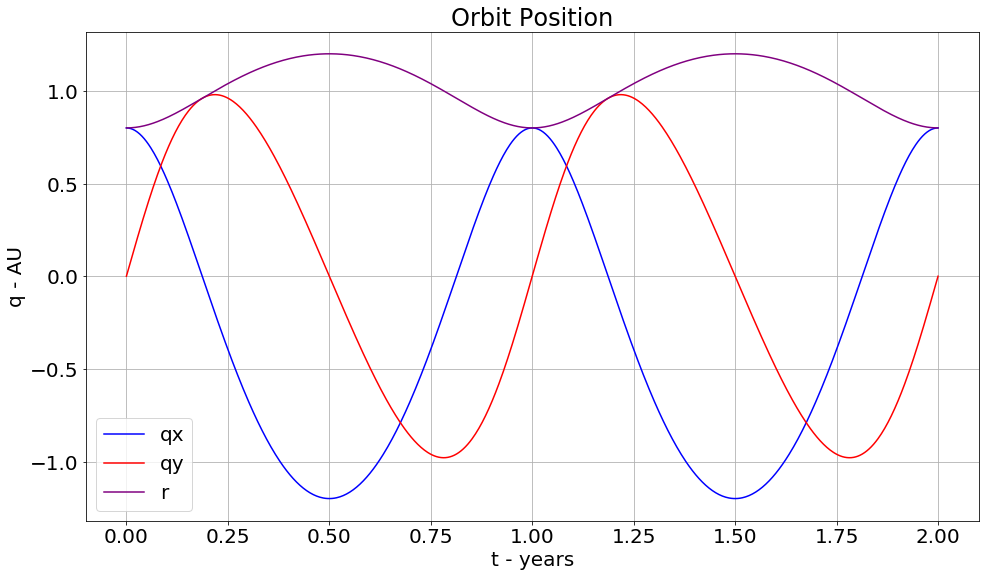

In [52]:
fig, ax = plot_orbit_q(data_traj)

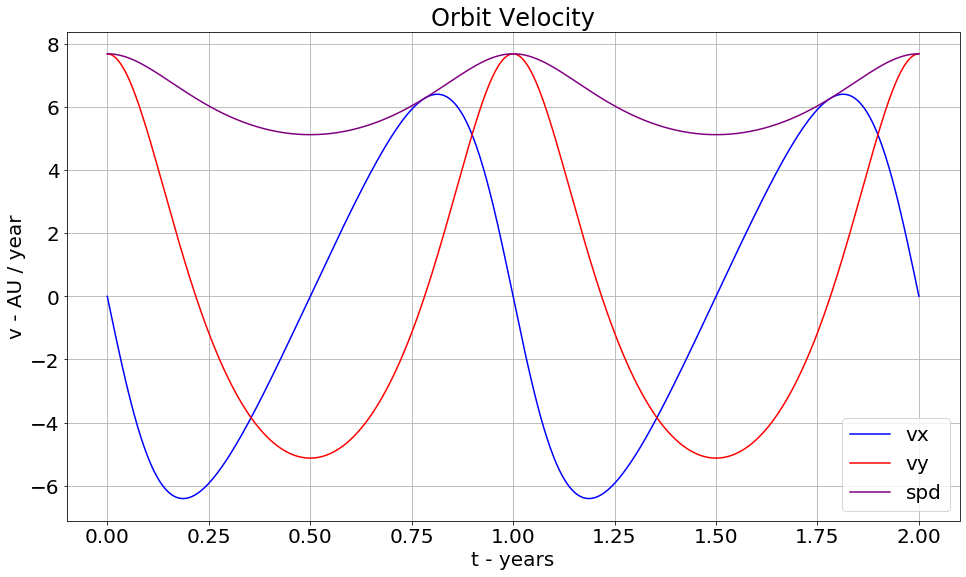

In [53]:
fig, ax = plot_orbit_v(data_traj)

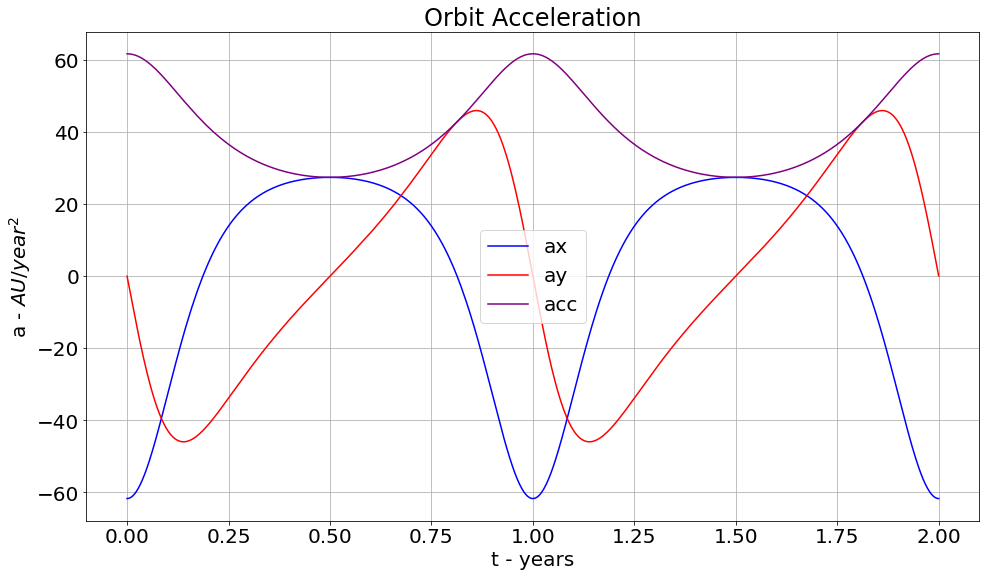

In [54]:
fig, ax = plot_orbit_a(data_traj)

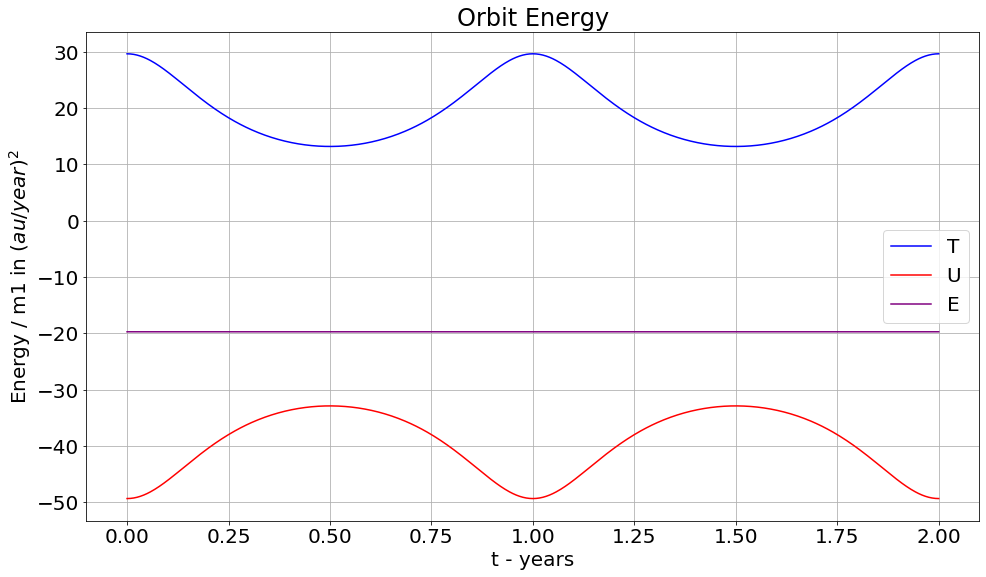

In [55]:
fig, ax = plot_orbit_energy(data_traj)

### Generate Training Data with a Range of Orbital Parameters

The function `make_train_r2b` creates training data for the restricted 2 body problem in the form of dictionaries of numpy arrays.  These are analogous to the outputs of `make_traj_r2b`, but there is an outer index of `n_traj` different trajectories.  The inputs `a_min`, `a_max`, `e_max`, and `inc_max` determine the sampling ranges for the parameters `a`, `e` and `inc` of the orbital elements of the starting configuration.  The other orbital elements (`Omega`, `omega`, `f`) are sampled over the full range of admissible values.<br>
The function `make_datasets_r2b` generates three tensorflow Dataset objects for train, validation and test, respectively.  Data is generated in the form of Numpy arrays using `make_train_r2b` because it is easier to serialize in that format.  The function checks on disk to see if the data is already available, and if so, loads it.  Otherwise it generates and then saves it.  Effective serialization is critical because the data set is expensive to generate.

In [11]:
# Inputs for make_train_r2b
n_traj = 10
n_years = 2
a_min = 0.50
a_max = 32.0
e_max = 0.20
inc_max = np.pi/4.0
seed = 42

In [12]:
# Test make_train_r2b
inputs, outputs= make_train_r2b(n_traj=n_traj, n_years=n_years, a_min=a_min, a_max=a_max, 
                                e_max=e_max, inc_max=inc_max, seed=seed)

In [13]:
# Inputs for make_datasets_r2b
n_traj = 100
vt_split = 0.20
n_years = 2

# The batch size (encapsulated in make_datasets_earth and make_datasets_solar)
batch_size = 64

In [14]:
# Create DataSet objects for toy size problem - earth orbits only (a=1, e=0)
ds_earth_trn, ds_earth_val, ds_earth_tst = make_datasets_earth(n_traj=n_traj, vt_split=vt_split, n_years=n_years)

Loaded data from ../data/r2b/2367906283.pickle.


In [15]:
# Create DataSet objects for toy size problem - solar system type orbits
ds_small_trn, ds_small_val, ds_small_tst = make_datasets_solar(n_traj=n_traj, vt_split=vt_split, n_years=n_years)

Loaded data from ../data/r2b/1421569704.pickle.


In [16]:
# Create a large data set with 100,000 solar system type orbits
n_traj = 100000

ds_trn, ds_val, ds_tst = make_datasets_solar(n_traj=n_traj, vt_split=vt_split, n_years=n_years)

Loaded data from ../data/r2b/2961698777.pickle.


**Generating 140,000 trajectories takes about 110 minutes on my server and uses about 4.6 GB of disk space.**

### Review One Example Batch of Training Data

In [17]:
# Example batch
batch_in, batch_out = list(ds_earth_trn.take(1))[0]
print('Input field names: ', list(batch_in.keys()))
print('Output field names:', list(batch_out.keys()))

t = batch_in['t']
q0 = batch_in['q0']
v0 = batch_in['v0']
mu = batch_in['mu']

q = batch_out['q']
v = batch_out['v']
a = batch_out['a']
q0_rec = batch_out['q0_rec']
v0_rec = batch_out['v0_rec']
H = batch_out['H']
L = batch_out['L']

print(f'\nExample batch sizes:')
print(f't  = {t.shape}')
print(f'q0 = {q0.shape}')
print(f'v0 = {v0.shape}')
print(f'mu = {mu.shape}')

print(f'q  = {q.shape}')
print(f'v  = {v.shape}')
print(f'a  = {a.shape}')
# print(f'q0_rec = {q0_rec.shape}')
# print(f'v0_rec = {v0_rec.shape}')
print(f'H  = {H.shape}')
print(f'L  = {L.shape}')

Input field names:  ['t', 'q0', 'v0', 'mu']
Output field names: ['q', 'v', 'a', 'q0_rec', 'v0_rec', 'T', 'U', 'H', 'L']

Example batch sizes:
t  = (64, 731)
q0 = (64, 3)
v0 = (64, 3)
mu = (64,)
q  = (64, 731, 3)
v  = (64, 731, 3)
a  = (64, 731, 3)
H  = (64, 731)
L  = (64, 731, 3)


In [18]:
traj_size = 731

tf.debugging.assert_shapes(
    shapes = {
    # Inputs
    t: (batch_size, traj_size),
    q0: (batch_size, 3),
    v0: (batch_size, 3),
    mu: (batch_size,),
    # Outputs
    q: (batch_size, traj_size, 3),
    v: (batch_size, traj_size, 3),
    a: (batch_size, traj_size, 3),
    q0_rec: (batch_size, 3),
    v0_rec: (batch_size, 3),
    H: (batch_size, traj_size),
    L: (batch_size, traj_size, 3),
    })

### Custom Keras Layers with Physics Computations of Energy and Angular Momentum

The module `r2b.py` contains shared elements used in the restricted 2 body problem.<br>
The layer `KineticEnergy_R2B` computes the kinetic energy (per unit of mass) of the orbiting body given its velocity `v` as a 3-vector.<br>
The kinetetic energy is $T = \frac{1}{2} |v|^2$ <br>
The layer `PotentialEnergy_R2B` computes the potential energy (per unit of mass) of the orbiting body given its position `q` as a 3-vector.  The gravitational field strength `mu` is a constant equating to 1 solar mass.  This could be adjusted to be an input variable, but I've left it constant for simplicity.<br>
The potential energy $U = -\mu / r$ where $r = |q|$.<br>
The layer `AngularMomentum_R2B` computes the specific angular momentum of the orbiting body given its position `q` and velocity `v`.<br>
The angular momentum $L = q \times v$, the 3D vector cross product.  The angular momentum is returned as a 3-vector, NOT as a scalar magnitude.  While technically the restricted two body problem can be solved by a coordinate change in a 2D plane, I wanted an approach that would generalize well to the three body problem.

In addition to the custom layers computing the physical quantities, there are also custom loss functions intended to be used with them.<br>
The custom loss function `VectorError` returns the relative error 
$$E = \frac{|y_{true} - y_{pred}|}{|y_{true}| + R}$$
where $R$ is an optional regularization term that defaults to 0.<br>
The custom loss function `EnergyError` returns a log scaled squared error
$$E = \log{\left[1 + \left(\frac{y_{pred} - y_{true}}{y_{true}}\right)^2\right]}$$
The log scaling is introduced so that the error doesn't blow up catastrophically when distance gets too small.  This was causing problems in training when an un-scaled energy error was used.

**Call layers with physics computations**

In [19]:
T = KineticEnergy_R2B()(v)
T.shape

TensorShape([64, 731])

In [20]:
U = PotentialEnergy_R2B()((q, mu))
U.shape

TensorShape([64, 731])

In [21]:
L = AngularMomentum_R2B()([q, v])
L.shape

TensorShape([64, 731, 3])

## Conversion of initial configuration to orbital elements

In [22]:
qx = q0[:,0]
qy = q0[:,1]
qz = q0[:,2]
vx = v0[:,0]
vy = v0[:,1]
vz = v0[:,2]
inputs_cart = (qx, qy, qz, vx, vy, vz, mu)

In [23]:
elts = ConfigToOrbitalElement()(inputs_cart)
a0, e0, inc0, Omega0, omega0, f0, M0, N0 = elts

In [24]:
# Review shapes
print(f'Example batch sizes:')
print(f'qx   = {qx.shape}')
print(f'vx   = {vx.shape}')
print(f'mu   = {mu.shape}')
print(f'a0   = {a0.shape}')

Example batch sizes:
qx   = (64,)
vx   = (64,)
mu   = (64,)
a0   = (64,)


In [25]:
# Display the numerical value of the graviational field strength mu in the (years, AU, solar masses) unit system
mu_reb = inputs['mu'][0]
print(f'mu = {mu_reb:20.12f}')
print(f'4 pi^2 =  {4*np.pi**2:10.12f}')

mu =      39.476924896240
4 pi^2 =  39.478417604357


### Mathematical Model - Predict Orbits Analytically Using Orbital Elements

A **position model** predicts the Cartesian position (qx, qy, qz) of the system as a function of a time.  It takes as inputs (t, q0, v0).  It also outputs velocities (vx, vy, vz) that are consistent with the orbital elements.  These will be exactly correct if the model is correct, i.e. if the 5 orbital elements other than `f` are constant, and if `f` is evolving consistently with the mean motion and Kepler's equation.<br>
A position model can be used to build a **motion model** which also outputs the (exact) velocity and acceleration based on the position as a function of time.  This is done using automatic differentiation.<br>
A motion model can in turn be used to create a **physics model**.  In addition to the position, velocity, and acceleration, this model also computes the physical quantities energy $H$ and angular momentum $L$.<br>
The idea of this design is to abstract the common steps of passing from a position model to a physics model so they do not need to be duplicated over different position models.  The module `r2b.py` includes a class `Motion_R2B` that implements this design.  The constructor accepts a position model as described above.  The `call` method of this model creates two GradientTape objects.  The inner-most scope computes the position coordinates (qx, qy, qz) from the inputs using the position model.  The next outer scope computes the velocity as the derivative of position w.r.t. time, e.g. `vx = gt1.gradient(qx, t)`.  The outermost scope similarly computes the acceleration as the derivative of velocity w.r.t. time.

The module `r2b_model_math` includes a function `make_position_model_r2b_math` that creates an analytical position model for solving the restricted 2 body problem.  The calculations proceed along the following outline:
* The initial conditions (q0, v0, mu) are converted to orbital elements (a0, e0, inc0, Omega0, omega0, f0).
* The initial mean anomaly M0 and mean motion N0 are also extracted in this step
* The orbital elements are repeated to match the trajectory size, e.g. 731.  So if a0 has a shape of (64,), a has a shape of (64,731)
* The mean anomaly M as a function of time is computed as M = M0 + N0 * t
* The mean anomaly M is converted to the true anomaly f using the layer MeanToTrueAnomaly([M, e])
* The complete set of orbital elements (a, e, inc, Omega, omega, f), each with shape (64, 731) is converted back to Cartesian coordinates

In [26]:
position_model_math = make_position_model_r2b_math(traj_size=traj_size)

In [27]:
qx, qy, qz, vx_, vy_, vz_ = position_model_math([t, q0, v0, mu])
print(f'qx = {qx.shape}')
print(f'qy = {qy.shape}')
print(f'qz = {qz.shape}')

qx = (64, 731, 1)
qy = (64, 731, 1)
qz = (64, 731, 1)


In [28]:
# keras.utils.plot_model(position_model_math, '../figs/model_plots/r2b/position_model_math.png')

In [29]:
# position_model_math.summary()

**Motion Model: Compute v and a from q using automatic differentiation**<br>
In the next section, we instantiate a motion model using mathematical position model.

In [30]:
motion_model_math = Motion_R2B(position_model=position_model_math, name='motion_model')

In [31]:
q, v, a = motion_model_math([t, q0, v0, mu])
print('shape of motion_model outputs:')
print(f'q: {q.shape}')
print(f'v: {v.shape}')
print(f'a: {a.shape}')

shape of motion_model outputs:
q: (64, 731, 3)
v: (64, 731, 3)
a: (64, 731, 3)


In [32]:
# Assemble vx_, vy_, vz_ into v_
v_ = keras.layers.concatenate([vx_, vy_, vz_])

# Compare v with v_
vel_err = v - v_

# Compute RMS error
rms_err = np.sqrt(np.mean(vel_err**2))
print(f'RMS error of recovered velocity from automatic differentiation vs. orbital elements:')
print(f'{rms_err:5.2E}')

RMS error of recovered velocity from automatic differentiation vs. orbital elements:
1.07E-04


In [33]:
np.sqrt(np.mean(vel_err**2))

0.00010732442

**The results are close, with an RMS around 1E-4.**<br>
There may be some noise in the interaction of the numerical, iterative solution of Kepler's equation and the automatic differentiation.

In [34]:
# motion_model_math.summary()

**Full physics model: computes energy and angular momentum from q, v**<br>
In the next section, we instantiate a full physics model from the same mathematical position model.<br>
This model is evloving the R2B system using Kepler's Equation and computing the physical quantities.

In [35]:
model_math = make_model_r2b_math()

In [36]:
model_math.summary()

Model: "model_math"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
t (InputLayer)                  [(None, 731)]        0                                            
__________________________________________________________________________________________________
q0 (InputLayer)                 [(None, 3)]          0                                            
__________________________________________________________________________________________________
v0 (InputLayer)                 [(None, 3)]          0                                            
__________________________________________________________________________________________________
mu (InputLayer)                 [(None, 1)]          0                                            
_________________________________________________________________________________________

## Review outputs of math model

In [37]:
q, v, a, q0_rec, v0_rec, H, L  = model_math([t, q0, v0, mu])
print(f'model output shapes:')
print(f'q = {q.shape}')
print(f'v = {v.shape}')
print(f'a = {a.shape}')
print(f'q0_rec = {q0_rec.shape}')
print(f'v0_rec = {v0_rec.shape}')
print(f'H = {H.shape}')
print(f'L = {L.shape}')

model output shapes:
q = (64, 731, 3)
v = (64, 731, 3)
a = (64, 731, 3)
q0_rec = (64, 3)
v0_rec = (64, 3)
H = (64, 731)
L = (64, 731, 3)


In [38]:
optimizer = keras.optimizers.Adam(learning_rate=1.0E-3)

loss = {'q': VectorError(name='q_loss'),
        'v': VectorError(name='v_loss'),
        'a': VectorError(regularizer=1.0, name='a_loss'),
        'q0_rec': VectorError(name='q0_loss'),
        'v0_rec': VectorError(name='v0_loss'),
        'H': EnergyError(name='H'),
        'L': VectorError(name='L'),
       }

metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 1.0,
                'q0_rec': 1.0,
                'v0_rec': 1.0,
                'H': 1.0,
                'L': 1.0}

In [39]:
# Compile the mathematical model on a single GPU
model_math.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [40]:
# Evaluate the math model on the earth-like data set
model_math.evaluate(ds_earth_trn)

2/2 [==============================] - 25s 13s/step - loss: 7.9047e-05 - q_loss: 4.3693e-08 - v_loss: 4.4132e-08 - a_loss: 7.8714e-05 - q0_rec_loss: 4.2763e-08 - v0_rec_loss: 1.9835e-07 - H_loss: 1.7512e-09 - L_loss: 2.6171e-09


[7.904716309781179e-05,
 4.3693163e-08,
 4.4131696e-08,
 7.8713856e-05,
 4.2762874e-08,
 1.983503e-07,
 1.7511931e-09,
 2.6170577e-09]

In [41]:
# Evaluate the math model on the solar system -like data set
model_math.evaluate(ds_val)

313/313 [==============================] - 19s 61ms/step - loss: 3.7548e-06 - q_loss: 8.0964e-08 - v_loss: 9.2683e-08 - a_loss: 1.3002e-07 - q0_rec_loss: 8.0956e-08 - v0_rec_loss: 3.2926e-06 - H_loss: 6.5865e-08 - L_loss: 1.1736e-08


[3.7547871146797267e-06,
 8.096393e-08,
 9.268256e-08,
 1.300168e-07,
 8.095561e-08,
 3.2925664e-06,
 6.58648e-08,
 1.17358105e-08]

In [ ]:
def make_position_model_r2b_nn(traj_size = 731):
    """
    Compute orbit positions for the restricted two body problem from 
    the initial orbital elements with a deterministic mathematical model.
    Factory function that returns a functional model.
    """
    # Create input layers 
    t = keras.Input(shape=(traj_size,), name='t')
    q0 = keras.Input(shape=(3,), name='q0')
    v0 = keras.Input(shape=(3,), name='v0')
    mu = keras.Input(shape=(1,), name='mu')
    
    # Wrap these up into one tuple of inputs for the model
    inputs = (t, q0, v0, mu)
    
    # Reshape the gravitational field strength from (batch_size,) to (batch_size, 1,)
    mu0 = keras.layers.Reshape((1,))(mu)

    # Tuple of inputs for the model converting from configuration to orbital elements
    inputs_c2e = (q0, v0, mu0)

    # Model mapping cartesian coordinates to orbital elements
    model_c2e = make_model_cfg_to_elt()
    
    # Extract the orbital elements of the initial conditions
    a0, e0, inc0, Omega0, omega0, f0, M0, N0 = model_c2e(inputs_c2e)

    # Reshape t to (batch_size, traj_size, 1)
    t_vec = keras.layers.Reshape(target_shape=(traj_size, 1), name='t_vec')(t)
    
    # Repeat the constant orbital elements to be vectors of shape (batch_size, traj_size)
    # a = keras.layers.RepeatVector(n=traj_size, name='a')(a0)
    e_ = keras.layers.RepeatVector(n=traj_size, name='e_')(e0)
    # inc = keras.layers.RepeatVector(n=traj_size, name='inc')(inc0)
    # Omega = keras.layers.RepeatVector(n=traj_size, name='Omega')(Omega0)
    # omega = keras.layers.RepeatVector(n=traj_size, name='omega')(omega0)
    # mu = keras.layers.RepeatVector(n=traj_size, name='mu_vec')(mu0)

    # Repeat initial mean anomaly M0 and mean motion N0 to match shape of outputs
    M0_vec = keras.layers.RepeatVector(n=traj_size, name='M0_vec')(M0)
    N0_vec = keras.layers.RepeatVector(n=traj_size, name='N0_vec')(N0)
    # Compute the mean anomaly M(t) as a function of time
    N_t = keras.layers.multiply(inputs=[N0_vec, t_vec])
    M_ = keras.layers.add(inputs=[M0_vec, N_t])

    # Compute the true anomaly from the mean anomly and eccentricity
    f_ = MeanToTrueAnomaly(name='mean_to_true_anomaly')([M_, e_])
    
    # Combine the trajectory-wide scalars into one feature of shape (batch_size, 14)
    # One row has 3+3+6 = 12 elements
    phi_traj = keras.layers.concatenate(
        inputs=[q0, v0, a0, e0, inc0, Omega0, omega0, N0], 
        name='phi_traj')
    
    # Repeat phi_traj traj_size times so it has a shape of (batch_size, traj_size, 14)
    phi_traj_vec = keras.layers.RepeatVector(n=traj_size, name='phi_traj_vec')(phi_traj)

    # Combine the following into an initial feature vector, phi_0
    # 1) The time t
    # 2) The repeated orbital elements (which remain constant); not including f0
    # 3) The computed mean anomaly M and true anomaly f
    phi_0 = keras.layers.concatenate(
        inputs=[t_vec, phi_traj_vec, M_, f_], 
        name='phi_0')
    
    # phi_n will update to the last available feature layer for the output portion
    phi_n = phi_0

    # First hidden layer if applicable
    if num_layers > 0:
        phi_1 = keras.layers.Dense(units=hidden_sizes[0], activation='tanh', name='phi_1')(phi_0)
        if skip_layers:
            phi_1 = keras.layers.concatenate(inputs=[phi_0, phi_1], name='phi_1_aug')
        phi_n = phi_1

    # Second hidden layer if applicable
    if num_layers > 1:
        phi_2 = keras.layers.Dense(units=hidden_sizes[1], activation='tanh', name='phi_2')(phi_1)
        if skip_layers:
            phi_2 = keras.layers.concatenate(inputs=[phi_1, phi_2], name='phi_2_aug')
        phi_n = phi_2

    # Compute the orbital elements from the final features
    r = keras.layers.Dense(
        units=1, kernel_initializer='zeros', bias_initializer='ones', name='r')(phi_n)
    
    
    # Wrap orbital elements into one tuple of inputs for layer converting to cartesian coordinates
    inputs_e2c = (a, e, inc, Omega, omega, f, mu,)
    
    # Convert from orbital elements to cartesian
    qx, qy, qz, vx, vy, vz = OrbitalElementToConfig(name='orbital_element_to_config')(inputs_e2c)
    
    # Wrap up the outputs
    outputs = (qx, qy, qz, vx, vy, vz)
    
    # Check shapes
    tf.debugging.assert_shapes(shapes={
        qx: (batch_size, traj_size, 1),
        qy: (batch_size, traj_size, 1),
        qz: (batch_size, traj_size, 1),
        vx: (batch_size, traj_size, 1),
        vy: (batch_size, traj_size, 1),
        vz: (batch_size, traj_size, 1),
    }, message='make_position_model_r2b_math / outputs')
    
    # Wrap this into a model
    model = keras.Model(inputs=inputs, outputs=outputs, name='model_r2b_math')
    return model